# WORKFLOW-CAGE Bacterial Infection Higher MOI

This document is an example of how to process a C1-CAGE library with a Jupyter notebook from raw reads to single molecule count. In the following section we assume that:
- The softwares used in this workflow are mentioned in the [prerequesite](https://github.com/Population-Transcriptomics/C1-CAGE-preview/blob/master/prerequisite.md) section.
- The reference genome has to be already indexed with bwa
- The tutorials are introduced with the example file mentioned in the tutorial

In our hands this notebook worked without trouble on a machine running Debian GNU/Linux 8. We noticed that the behavior of tagdust2 in single-end mode was different on Mac OSX. In short, the order of the reads1 is changed after extraction on Mac OSX which is a problem because syncpairs expect the order of reads1 and reads2 to be the same. One way to overcome this issueis sort reads1 and reads2 separately after the exctraction then syncpairs will work properly.

## Setting the Input and Output Folder

In [1]:
# Setting the output folder where all the results would be stored
outputFolder = '/home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow_Higher_MOI/output/'

# inputFolder : Folder name with all the fastq files
intputFolder = '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/'

## Imports

In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
#from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import pylab

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library("dplyr")
library("edgeR")
library("ggplot2")
library("cowplot")
library("BASiCS")
library("scde")
library(repr)
library(biomaRt)
library(GO.db)
library(extRemes)
library(Lmoments)
library(distillery)
library(car)
theme_set(theme_bw(base_size = 16))

## Custom functions

In [6]:
remove_extension = lambda x: x.split('.')[0]

Declare the function that deals with inputs and outputs

In [7]:
def get_args(read1, read2, ref_genome, bacterial_ref_genome, output_folders):
    '''Set the input and output path for a given pair of reads'''
    r1_shortname = remove_extension(os.path.basename(read1))

    args = {  
        'r1_input': read1,
        'r2_input': read2,
        'ref_genome': ref_genome,
        'bacterial_ref_genome': bacterial_ref_genome,
    }
    
    output_paths = {folder: os.path.join(outputFolder, folder, r1_shortname) for folder in output_folders}
    
    return dict(args, **output_paths)

In [8]:
def ERCC_finder(f):
    full_path = cleanedReadsFolder + f
    file_ERCC = open(full_path,'rb')
    ERCCTempFilePath = outputFolder + 'ERCC_count/ERCC_count_'
    for line in file_ERCC:
        if 'ERCC' in line:
            temp = str.split(line)            
            ERCC_file_path = ERCCTempFilePath + f.split('_', 1)[0]+".txt"            
            ERCC_command_file = open(ERCC_file_path, 'a')
            ERCC_line_to_write = temp[3] + "\t" + temp[2]+ "\n"
            ERCC_command_file.writelines(ERCC_line_to_write)
            ERCC_command_file.close

In [9]:
def expanderuser(path):
    """Replaces the ~ with the users home directory"""
    if path.startswith("~"):
        return os.path.expanduser("~") + path[1: ]
    return path

def multiple_match(regex, old_name, name):
    report_error(regex+" matched both " + old_name + " and " + name + "strickter regex required")

def do_walk(source, regex, target_path, onerror=None, followlinks=False, verbose=True, divider=None, sort=None):
    """
    Walker method
    Inputs are:
    source Parent directory to be walked through
    onerror is a function on underlying os.listdir fails
    followlinks would allow following symbolic links
        WARNING Be aware that setting followlinks to True can lead to infinite
           recursion if a link points to a parent directory of itself.
           walk() does not keep track of the directories it visited already.
    verbose: Flag passed to action methods to provide more output
    """
    source = expanderuser(source)
    (names_number, names_path) = tempfile.mkstemp()
    re_object = re.compile(regex)
    file_paths = []
    with open(names_path, 'w') as f:
        # Must be topdown=True otherwise walk will process subdirectories before checking them
        for root, dirs, files in os.walk(source, topdown=True, onerror=onerror, followlinks=followlinks):
            for name in files:
                if re_object.search(name):
                    file_path = os.path.join(root, name)
                    f.write(file_path)
                    f.write("\n")
                    file_paths.append(file_path)
                    if verbose:
                        print "Merging",file_path
                #else:
                #    print "NO",name, root
    if len(file_paths) == 0:
        report_error("NO files found to match "+ regex)
    if divider:
        if sort:
            merge_files(file_paths, names_path, target_path, verbose=verbose, divider = divider, sort = sort)
        else:
            merge_files(file_paths, names_path, target_path, verbose=verbose, divider = divider)
    else:
        if sort:
            merge_files(file_paths, names_path, target_path, verbose, sort=sort)
        else:
            merge_files(file_paths, names_path, target_path, verbose)


In [10]:

def report_error(error):
    """Prints the error, and exits -1"""
    print error
    sys.stderr.write(error)
    sys.stderr.write("\n")
    sys.stderr.flush()
    sys.exit(1)


def remove_common(names):
    start = names[0]
    end = names[0]
    for name in names:
        while len(start) > 0 and not(name.startswith(start)):
            start = start[: -1]
        while len(end) > 0 and not(name.endswith(end)):
            end = end[1:]
    new_names = []
    for name in names:
        new_name = name[len(start): -len(end)]
        new_names.append("C"+new_name)
    return new_names


def remove_symbols(s):
    if s.find("__") == -1:
        return s
    # Patterns used by Galaxy
    s = s.replace("__cb__", ']')
    s = s.replace("__cc__", '}')
    s = s.replace("__dq__", '"')
    s = s.replace("__lt__", '<')
    s = s.replace("__gt__", '>')
    s = s.replace("__ob__", '[')
    s = s.replace("__oc__", '{')
    s = s.replace("__sq__", "'")
    # Patterns added by Christian
    s = s.replace("__in__", '%in%')
    s = s.replace("__not__", '!')
    end = -2
    # tab = 9
    # | = 124
    while True:
        start = s.find("__", end + 2) + 2
        if start == 1:
            return s
        end = s.find("__", start)
        if end == -1:
            return s
        part = s[start: end]
        try:
            ascii = int(part)
            s = s.replace("__" + part + "__", chr(ascii))
            end = -2
        except ValueError:
            pass
    return s


def clean_part(part):
    part = part.strip()
    part = part.replace("\t", "__9__")
    return part


def return_blank():
    return "0"


def black_dict():
    return collections.defaultdict(return_blank)


def merge_files(file_paths, names_path, target_path, verbose=False, divider="\t", sort = None):
    if sort:
        if sort == "column_names":
            column_sort = True
            row_sort = False
        elif sort == "row_names":
            column_sort = False
            row_sort = true
        elif sort == "both":
            column_sort = True
            row_sort = True
        elif sort == "none":
            column_sort = False
            row_sort = False
        else:
            report_error("Unexpected value: " + sort + " for sort parameter. Legeal values are: column_names, row_names, both or none")
    else:
        column_sort = False
        row_sort = False

    names = []
    with open(names_path, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) > 0:
                names.append(line)
    if len(names) != len(file_paths):
        report_error("Found " + str(len(file_paths)) + " file_paths but " + names_path + " contains " + str(len(names)) + " lines.")
    new_names = remove_common(names)
    clean_divider = remove_symbols(divider)
    all_values = collections.defaultdict(black_dict)
    for count, file_path in enumerate(file_paths):
        mis_match = 0
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split(clean_divider)
                if len(parts) == 2:
                    key = clean_part(parts[0])
                    value = clean_part(parts[1])
                    all_values[key][new_names[count]] = value
                else:
                    mis_match+= 1
                    if verbose:
                        if mis_match < 5:
                            print "ignoring following line from", file_path
                            print line
        if mis_match > 0:
            print "In file " + file_path + " " + str(mis_match) + " lines did not have 1 divider (" + clean_divider + ") " + divider

    if column_sort:
        new_names = sorted(new_names)
    if row_sort:
        row_names = sorted(all_values.keys())
    else:
        row_names = all_values.keys()

    with open(target_path, 'w') as f:
        for name in new_names:
            f.write("\t")
            f.write(name)
        f.write("\n")
        for key in row_names:
            f.write(key)
            for name in new_names:
                f.write("\t")
                f.write(all_values[key][name])
            f.write("\n")

## Parameters

If the required softwares are not in the PATH you can manually set their location here

In [10]:
tagdust2_path = 'tagdust'
bwa_path = '/home/baker/bwa/bwa'
samtools_path = 'samtools'
paired_bam_to_bed12_path = '/home/baker/pairedBamToBed12/bin/pairedBamToBed12'
umicountFP_path = 'umicountFP'
syncpairs_path = 'syncpairs'
bedToBam_path = 'bedToBam'
featureCount_path = '/home/baker/Downloads/subread-1.5.0-p1-source/bin/featureCounts'

Path to the reference genome you want to align your reads against

In [11]:
#ref_genome = '/home/baker/my-mm10-index-share/Mus_musculus.GRCm38.71.fa'
ref_genome = '/home/baker/my-mm10-index-share/bwa/bwa_mm10_random_chrM_chrUn'
bacterial_ref_genome = '/home/baker/my-genomeIndex-share/L.monocytogenes/bwa/genome'

In [12]:
softwares = {    
    'bwa': bwa_path,
    'tagdust': tagdust2_path,
    'syncpairs': syncpairs_path,
    'samtools': samtools_path,
    'pairedBamToBed12': paired_bam_to_bed12_path,
    'umicountFP': umicountFP_path,
    'bedToBam': bedToBam_path,
    'featureCount':featureCount_path}

The name of the output folders for each command

In [13]:
output_folders = [ 'tagdust_r1', 'unzip_r2'                    # Demultiplexed R1, unziped R2
                 , 'extracted_r1', 'extracted_r2'              # Synced R1 and R2
                 , 'cleaned_reads', 'cleaned_r1', 'cleaned_r2' # rRNA reads removed
                 , 'r1_sai', 'r2_sai', 'sampe'                 # Intermediate files from BWA
                 , 'genome_mapped', 'properly_paired'          # Final output in BAM format
                 , 'cagescan_pairs', 'cagescan_fragments'      # Final output in BED12 format
                 , 'htseq_output', 'ERCC_count'                # Htseq-count and ERCC-Spike in counts
                 , 'bedToBam_output','featureCount_output'
                 , 'sampeBacteria', 'bacterial_genome_mapped'
                 ]

Create the folders

In [29]:
for folder in output_folders:
    os.makedirs(os.path.join(outputFolder, folder))

The actual command to run. See the [tutorial](https://github.com/Population-Transcriptomics/C1-CAGE-preview/blob/master/tutorial.md) section for more details about each command

### Samtools Flags

Flag Description (The way I used):
- 0x0001 Paired in sequencing
- __0x0002 Mapped in proper read pair__
- 0x0004 Query unmapped
- 0x0008 Mate unmapped
- 0x0010 Strand of the query (1 for reverse)
- 0x0020 Strand of the mate (1 for reverse)
- 0x0040 First read in the pair
- 0x0080 Second read in the pair
- __0x0100 Secondary alignment__
- 0x0200 QC failure
- 0x0400 Optical or PCR duplicates

Flag Description (The way mentioned in samtools help):
- 0x1	PAIRED	paired-end (or multiple-segment) sequencing technology
- 0x2	PROPER_PAIR	each segment properly aligned according to the aligner
- 0x4	UNMAP	segment unmapped
- 0x8	MUNMAP	next segment in the template unmapped
- 0x10	REVERSE	SEQ is reverse complemented
- 0x20	MREVERSE	SEQ of the next segment in the template is reverse complemented
- 0x40	READ1	the first segment in the template
- 0x80	READ2	the last segment in the template
- 0x100	SECONDARY	secondary alignment
- 0x200	QCFAIL	not passing quality controls
- 0x400	DUP	PCR or optical duplicate
- 0x800	SUPPLEMENTARY	supplementary alignment

If you want to extract reads that mapped only to a certain strand of the reference, you can use the -F and -f flags in samtools:

__for positive strand__<br>
samtools view -F 0x10 -b input.bam > postiveStrand.sam

__for negative strand __<br>
samtools view -f 0x10 -b input.bam > negativeStrand.sam 

The 0x10 flag of the bitwise flags indicates whether the read is reverse complemented or not. If 0x10 is set, then the read mapped to the reverse strand. If it is not set, then the read mapped to the positive strand.

The -F parameter with 0x10 will skip anything that has 0x10 set, meaning it will skip anything that mapped to the reverse strand. The -f parameter will only keep anything that has 0x10 set.

__Samtools view options__

 OPTIONS:

-b

    Output in the BAM format. 
-C

    Output in the CRAM format (requires -T). 
-1

    Enable fast BAM compression (implies -b). 
-u

    Output uncompressed BAM. This option saves time spent on compression/decompression and is thus preferred when the output is piped to another samtools command. 
-h

    Include the header in the output. 
-H

    Output the header only. 
-c

    Instead of printing the alignments, only count them and print the total number. All filter options, such as -f, -F, and -q, are taken into account. 
-?

    Output long help and exit immediately. 
-o FILE

    Output to FILE [stdout]. 
-U FILE

    Write alignments that are not selected by the various filter options to FILE. When this option is used, all alignments (or all alignments intersecting the regions specified) are written to either the output file or this file, but never both. 
-t FILE

    A tab-delimited FILE. Each line must contain the reference name in the first column and the length of the reference in the second column, with one line for each distinct reference. Any additional fields beyond the second column are ignored. This file also defines the order of the reference sequences in sorting. If you run: `samtools faidx <ref.fa>', the resulting index file <ref.fa>.fai can be used as this FILE. 
-T FILE

    A FASTA format reference FILE, optionally compressed by bgzip and ideally indexed by samtools faidx. If an index is not present, one will be generated for you. 
-L FILE

    Only output alignments overlapping the input BED FILE [null]. 
-r STR

    Only output alignments in read group STR [null]. 
-R FILE

    Output alignments in read groups listed in FILE [null]. 
-q INT

    Skip alignments with MAPQ smaller than INT [0]. 
-l STR

    Only output alignments in library STR [null]. 
-m INT

    Only output alignments with number of CIGAR bases consuming query sequence ≥ INT [0] 
-f INT

    Only output alignments with all bits set in INT present in the FLAG field. INT can be specified in hex by beginning with `0x' (i.e. /^0x[0-9A-F]+/) or in octal by beginning with `0' (i.e. /^0[0-7]+/) [0]. 
-F INT

    Do not output alignments with any bits set in INT present in the FLAG field. INT can be specified in hex by beginning with `0x' (i.e. /^0x[0-9A-F]+/) or in octal by beginning with `0' (i.e. /^0[0-7]+/) [0]. 
-x STR

    Read tag to exclude from output (repeatable) [null] 
-B

    Collapse the backward CIGAR operation. 
-s FLOAT

    Integer part is used to seed the random number generator [0]. Part after the decimal point sets the fraction of templates/pairs to subsample [no subsampling]. 
-@ INT

    Number of BAM compression threads to use in addition to main thread [0]. 
-S

    Ignored for compatibility with previous samtools versions. Previously this option was required if input was in SAM format, but now the correct format is automatically detected by examining the first few characters of input. 

### bwa mem -M option
"Changed the way a chimeric alignment is reported (conforming to the upcoming
SAM spec v1.5). With 0.7.5, if the read has a chimeric alignment, the paired
or the top hit uses soft clipping and is marked with neither 0x800 nor 0x100
bits. All the other hits part of the chimeric alignment will use hard
clipping and be marked with 0x800 if option "-M" is not in use, or marked
with 0x100 otherwise __(Seondary Alignment)__."

In [14]:
cmds = [
    
    '{tagdust} -t8 -o {tagdust_r1} -1 F:NNNNNNNN -2 S:TATAGGG -3 R:N {r1_input}',
    
    'gunzip -c {r2_input} > {unzip_r2}.fq',
        
    '{syncpairs} {tagdust_r1}.fq {unzip_r2}.fq {extracted_r1}.fq {extracted_r2}.fq',
    
    '{tagdust} -arch SimpleArchitecture.txt -ref /home/baker/Rna-seq_Data-Analysis/Pawel_Pascaz_Bacterial/ERCC92.fa -o {cleaned_reads} {extracted_r1}.fq {extracted_r2}.fq',
    
    'cp {cleaned_reads}_READ1.fq {cleaned_r1}.fq',
    
    'cp {cleaned_reads}_READ2.fq {cleaned_r2}.fq',
    
    '{bwa} mem -M {ref_genome} {cleaned_r1}.fq {cleaned_r2}.fq > {sampe}.sam',
    
    '{bwa} mem -M {bacterial_ref_genome} {cleaned_r1}.fq {cleaned_r2}.fq > {sampeBacteria}.sam',
    
    '{samtools} view -uSo - {sampe}.sam | {samtools} sort - {genome_mapped}',
    
    '{samtools} flagstat {genome_mapped}.bam >{genome_mapped}.Logfile',
    
    '{samtools} view -uSo - {sampeBacteria}.sam | {samtools} sort - {bacterial_genome_mapped}',
    
    '{samtools} flagstat {bacterial_genome_mapped}.bam >{bacterial_genome_mapped}.Logfile',
    
    '{samtools} view -f 0x0002 -F 0x0100 -uo - {genome_mapped}.bam | {samtools} sort -n - {properly_paired}',
    
    '{pairedBamToBed12} -i {properly_paired}.bam > {cagescan_pairs}.bed',
    
    '{umicountFP} -f {cagescan_pairs}.bed > {cagescan_fragments}.bed',
    
    '{bedToBam} -i {cagescan_fragments}.bed -g /home/baker/my-hydra-share/Packages/MouseChromosome/chrom.sizes > {bedToBam_output}.bam',
    
    '{samtools} sort {bedToBam_output}.bam {bedToBam_output}_sorted',
    
    '{samtools} view -bh {bedToBam_output}_sorted.bam > {bedToBam_output}_sorted_header.bam'    
    
    
]

Get the reads. Here we assume that the reads are in the current directory, in a folder named following the MiSeq run id

In [16]:
root, folders, files = os.walk(intputFolder).next()

files = [f for f in files if not f.startswith('.')] #remove hidden files if there exist
reads1 = sorted([os.path.join(root, f) for f in files if 'R1' in f])
reads2 = sorted([os.path.join(root, f) for f in files if 'R2' in f])

In [17]:
print reads1, reads2

['/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C01_S17_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C02_S9_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C03_S1_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C04_S65_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C05_S57_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C06_S49_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C07_S18_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C08_S10_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C09_S2_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C10_S66_R1_001.fastq.gz', '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/C11_S

Run the commands for all the pairs

In [30]:
for read1, read2 in zip(reads1, reads2):
    args = get_args(read1, read2, ref_genome, bacterial_ref_genome, output_folders)
    args = dict(args, **softwares)    
    for cmd in cmds:        
        #print cmd.format(**args)
        subprocess.call(cmd.format(**args), preexec_fn=lambda: signal.signal(signal.SIGPIPE, signal.SIG_DFL), shell=True)

In [18]:
FeatureCountFolder = outputFolder + 'featureCount_output/'
bedToBamOutputFolder = outputFolder + 'bedToBam_output/'
root, folders, files = os.walk(bedToBamOutputFolder).next()
files = [os.path.join(root, f) for f in files if f.endswith('_sorted_header.bam')]
files = sorted(files)
featureCountCmd = '/home/baker/Downloads/subread-1.5.0-p1-source/bin/./featureCounts -p -t exon -g gene_id -a /home/baker/my-mm10-index-share/annotation/Gencode-M5/gencode.vM5.annotation.gtf -o '+ FeatureCountFolder+'AllFeatureCounts.txt '
for f in files:   
    featureCountCmd = featureCountCmd + f + ' '    
subprocess.call(featureCountCmd, shell=True)
#print featureCountCmd

0

__Extracting the counts mapped with Bacterial Genome__

In [19]:
BacterialGenomeFolder = outputFolder + 'bacterial_genome_mapped/'
root, folders, files = os.walk(BacterialGenomeFolder).next()
files = [os.path.join(root, f) for f in files if f.endswith('.Logfile')]
files = sorted(files)

BacterialCountFile = BacterialGenomeFolder + 'BacteriaCount.txt'
BacterialCount = "CellName"+ "\t" + "Counts" + "\t" + "PercentMapped \n"

for f in files:
    file_Bacteria = open(f,'rb')
    for line in file_Bacteria:
        if "mapped (" in line :
            BacterialCount = BacterialCount + f.rsplit('/', 1)[1].rsplit('_',3)[0] + '\t' + line.rsplit('+', 1)[0] + '\t' + line.rsplit('(', 1)[1].split('%', 1)[0]+'\n' 
        

target = open(BacterialCountFile, 'w')
target.write(BacterialCount)
target.close()

__Extracting the counts mapped with Mouse Genome__

In [20]:
MouseGenomeFolder = outputFolder + 'genome_mapped/'
root, folders, files = os.walk(MouseGenomeFolder).next()
files = [os.path.join(root, f) for f in files if f.endswith('.Logfile')]
files = sorted(files)

MouseCountFile = MouseGenomeFolder + 'MouseCount.txt'
MouseCount = "CellName"+ "\t" + "Counts" + "\t" + "PercentMapped \n"

for f in files:
    file_Mouse = open(f,'rb')
    for line in file_Mouse:
        if "mapped (" in line :
            MouseCount = MouseCount + f.rsplit('/', 1)[1].rsplit('_',3)[0] + '\t' + line.rsplit('+', 1)[0] + '\t' + line.rsplit('(', 1)[1].split('%', 1)[0]+'\n' 
        

target = open(MouseCountFile, 'w')
target.write(MouseCount)
target.close()

Generate the level1 file (__We are not using it at the moment__)

In [149]:
genomeMapped = outputFolder + 'genome_mapped/'
root, folders, files = os.walk(genomeMapped).next()
files = [os.path.join(root, f) for f in files if f.endswith('bam')]
level1 = 'python /home/baker/PromoterPipeline_20150516/level1.py -o /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_Feature_Count/output/mylevel1file.l1.osc.gz -f 0x0042 -F 0x0104 --fingerprint {files}'.format(files=' '.join(files))

In [150]:
subprocess.call(level1, shell=True)

0

## Generate logs (triplet)

Here we generate four summary files that will be used for [QC](https://github.com/Population-Transcriptomics/C1-CAGE-preview/blob/master/QC.md) and place them in the 'output' directory. 

1.  mapped.log: The number of mapped reads per cell
2.  extracted.log: The number of remaining reads after filtering for ribosomal DNA and unreadable UMIs
3.  filtered.log: The detailed number of ribosomal DNA extracted per cell
4.  transcript_count.log: The exact number of unique transcprit per cell



In [154]:
mapped_cmd = "{samtools} view -u -f 0x40 {genome_mapped}.bam | {samtools} flagstat - | grep mapped | grep % | cut -f 1 -d ' '"
extracted_cmd = "{samtools} flagstat {genome_mapped}.bam | grep read1 | cut -f 1 -d ' '"
counts_cmd = "wc -l {cagescan_fragments}.bed | cut -f 1 -d ' '"
rdna_cmd = "grep ribosomal {cleaned_reads}_logfile.txt | cut -f 2"

In [155]:
#remove _R1 from the file's name
custom_rename = lambda x: x.replace('_R1', '')

In [156]:
mapped, extracted, rdna, counts = ([], [], [], [])

for read1 in reads1:
    r1_shortname = remove_extension(os.path.basename(read1))
    
    args = {'samtools': samtools_path,
            'genome_mapped': os.path.join(outputFolder, 'genome_mapped', r1_shortname),
            'cagescan_fragments': os.path.join(outputFolder, 'cagescan_fragments', r1_shortname),
            'cleaned_reads': os.path.join(outputFolder, 'cleaned_reads', r1_shortname)}
    
    output = subprocess.check_output(mapped_cmd.format(**args), shell=True).strip()
    mapped.append(['mapped', custom_rename(r1_shortname), output])

    output = subprocess.check_output(extracted_cmd.format(**args), shell=True).strip()
    extracted.append(['extracted', custom_rename(r1_shortname), output])
    
    output = subprocess.check_output(counts_cmd.format(**args), shell=True).strip()
    counts.append(['counts', custom_rename(r1_shortname), output])

    output = subprocess.check_output(rdna_cmd.format(**args), shell=True).strip()
    rdna.append(['rdna', custom_rename(r1_shortname), output])
    #print rdna_cmd.format(**args)

In [157]:
mappedFile = outputFolder + 'mapped.log'
with open(mappedFile, 'w') as handler:
    writer = csv.writer(handler, delimiter='\t')
    writer.writerows(mapped)

extractedFile = outputFolder + 'extracted.log'
with open(extractedFile, 'w') as handler:
    writer = csv.writer(handler, delimiter='\t')
    writer.writerows(extracted)

filteredFolder = outputFolder + 'filtered.log'    
with open(filteredFolder, 'w') as handler:
    writer = csv.writer(handler, delimiter='\t')
    writer.writerows(rdna)

transctiptFolder = outputFolder + 'transcript_count.log'    
with open(transctiptFolder, 'w') as handler:
    writer = csv.writer(handler, delimiter='\t')
    writer.writerows(counts)

### Generating commands for htseq-count runs

In [ ]:
log_files = ""
properlyPairedFolder = outputFolder + 'properly_paired/'
root, folders, files = os.walk(properlyPairedFolder).next()
htseq_command=""
htseqFile = outputFolder + 'htseq_command.txt'
for f in files:   
    htseq_command_file = open(htseqFile, 'a')
    htseq_command = "qsub run_htseq-count output/properly_paired/" + f + " output/htseq_output/"+f.split('_', 1)[0]+"_htseq_count.txt\n"
    htseq_command_file.writelines(htseq_command)
    htseq_command_file.close
        #htseq_command.append(["qsub run_htseq-count", f])


__Generating command for ERCC-count__

In [ ]:
properlyPairedFolder = outputFolder + 'properly_paired/'
root, folders, files = os.walk(properlyPairedFolder).next()
htseq_command=""
htseqFile = outputFolder + 'ERCC_command.txt'
for f in files:   
    htseq_command_file = open(htseqFile, 'a')
    htseq_command = "qsub -pe smp.pe 2 run_htseq_ERCC-count output/properly_paired/" + f + " output/ERCC_Reads/"+f.split('_', 1)[0]+"_ERCC_count.txt\n"
    htseq_command_file.writelines(htseq_command)
    htseq_command_file.close

In [151]:
cleanedReadsFolder = outputFolder + 'cleaned_reads/'
root, folders, files = os.walk(cleanedReadsFolder).next()
files = [os.path.join("", f) for f in files if f.endswith('txt')]

In [152]:
for f in files:    
    ERCC_val = ERCC_finder(f)

__Combinging htseq count files and ERRC count files__

In [47]:
HTSEQFolder = outputFolder + 'htseq_output/'
HTSEqFile = outputFolder + 'AllHtseqCounts.tsv'
do_walk(HTSEQFolder, 'htseq_count.txt', HTSEqFile, onerror=None, followlinks=False, verbose=True, divider=None, sort="both")

Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C80_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C69_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C17_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C08_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C73_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C20_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/htseq_output/C77_htseq_count.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_se

In [153]:
ERCCFolder = outputFolder + 'ERCC_count/'
ERCCFile = outputFolder + 'AllERCC_Counts.tsv'
do_walk(ERCCFolder, 'ERCC_count_', ERCCFile, onerror=None, followlinks=False, verbose=True, divider=None, sort="both")

Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C85.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C48.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C84.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C64.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C75.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C02.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C83.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C69.txt
Merging /home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow/output/ERCC_count/ERCC_count_C04.txt
Merging /home/baker/my-scratch-share/

***
# Downstream analysis with BASiCS

**BASiCS** (Bayesian Analysis of Single-Cell Sequencing data) is an integrated Bayesian hierarchical model where: 

1. Cell-specific normalization constants are estimated as part of the model parameters, 

2. Technical variability is quantified based on spike-in genes that are artificially introduced to each analysed cells lysate and 

3. The total variability of the expression counts is decomposed into technical and biological components. 

BASiCS also provides an intuitive detection criterion for highly (or lowly) variable genes within the population of cells under study. This is formalized by means of tail posterior probabilities associated to high (or low) biological cell-to-cell variance contributions, quantities that can be easily interpreted by applied users. 

Here, we demonstrate how to use BASiCS using a simulated dataset. 



***

## The BASiCS model

Throughout, we analyse the expression counts of $q$ genes, where $q_0$ are expressed in the population of cells under study (biological genes) and the remaining $q-q_0$ are spike-in (technical) genes. Let $X_{ij}$ be a random variable representing the expression count of a gene $i$ in cell $j$  ($i=1,\ldots,q$; $j=1,\ldots,n$). BASiCS is based on the following hierarchical model:
$$X_{ij}  \big| \mu_i, \phi_j, \nu_j, \rho_{ij} \sim \left\{ \begin{array}{ll} \mbox{Poisson}(\phi_j \nu_j \mu_i \rho_{ij}), \mbox{  for }i=1,\ldots,q_0, j=1,\ldots,n \\ \mbox{Poisson}(\nu_j \mu_i), \mbox{  for }i=q_0+1,\ldots,q, j=1,\ldots,n, \end{array} \right.$$

where $\nu_j$ and $\rho_{ij}$ are mutually independent random effects such that $\nu_j|s_j,\theta \sim \mbox{Gamma}(1/\theta,1/ (s_j \theta))$ and $\rho_{ij} | \delta_i \sim \mbox{Gamma} (1/\delta_i,1/\delta_i)$[^footnoteGamma]. In the previous equation, the model parameters can be interpreted as:

* $\mu_i$: normalized expression rate of a gene $i$ in the population of cells under study. In case of the spike-in technical genes, $\mu_i$ is assumed to be known (and equal to the input number of molecules of the corresponding spike-in gene).

* $\rho_{ij}$: random effects related to biological cell-to-cell expression heterogeneity of a gene $i$ across the population of cells under study. 

* $\delta_i$: variance of $\rho_{ij}$, controlling the strength of the biological cell-to-cell expression heterogeneity of a gene $i$ across the population of cells under study. 

* $\phi_j$: cell-specific normalizing constants related to differences in mRNA content. For identifiability reasons, we impose the constrain: $\sum_{j=1}^n \phi_j = n$. 

* $s_j$: cell-specific normalizing constants related to differences in capture efficiency (when analyzing UMI based expression counts) and other amplification biases such as sequencing depth (when analyzing non-UMI based expression counts, as generated by standard scRNA-seq experiments).

* $\nu_j$: random effects related to cell-to-cell technical variability. These parameters oscilate around the normalizing constants $s_j$.

* $\theta$: variance of $\nu_j$, controlling the strenght of cell-to-cell technical variability. 

[^footnoteGamma]: We parametrize the Gamma distribution such that if $X \sim \mbox{Gamma}(a,b)$, then $\mbox{E}(X)=a/b$ and $\mbox{var}(X)=a/b^2$.
***
###  The input dataset

The input dataset for BASiCS must contain the following 3 elements:

* `Counts`: a matrix of raw expression counts with dimensions $q$ times $n$. First $q_0$ rows must correspond to biological genes. Last $q-q_0$ rows must correspond to technical spike-in genes.

* `Tech`: a vector of `TRUE`/`FALSE` elements with length $q$. If `Tech[i] = FALSE` the gene `i` is biological; otherwise the gene is spike-in.

* `SpikeInput`: a vector of length $q-q_0$ whose elements contain the input number of molecules for the spike-in genes (amount per cell).

These elements must be stored into an object of class `BASiCS_Data`.

In [57]:
%%R
CountData <- read.table('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/AllHtseqCounts.tsv',header=TRUE, sep='\t',row.names=1)
CellNumber <- dim(CountData)[2]

In [58]:
%%R
head(CountData)

                      C01 C02 C03 C04 C05 C06 C07 C08 C09 C10 C11 C12 C13 C14
ENSMUSG00000000001.4    0 129   0   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000003.12   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000028.11  36   0   0   0   0   0   0   0   0   0   0   7   0   0
ENSMUSG00000000031.12   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000037.13   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000049.8    0   0   0   0   0   0   0   0   0   0   0   0   0   0
                      C15 C16 C17 C18 C19 C20 C21 C22 C23 C24 C25 C26 C27 C28
ENSMUSG00000000001.4    0   0   0   0   0   0  23   0   0   0   0   0   0   0
ENSMUSG00000000003.12   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000028.11  20   0   3   0   0   0   0   0   0   0   0  14   0   0
ENSMUSG00000000031.12   0   0   0   0   0   1   0   0   0   0   0   0   0   0
ENSMUSG00000000037.13   0   0   0   0   0   0   0   0   0   0   

## Generating summary

In [60]:
%%R
# summary_data <- data.frame(CellNumber= character(CellNumber), Assigned_Reads=numeric(CellNumber),alignment_not_unique=numeric(CellNumber),ambiguous=numeric(CellNumber),no_feature=numeric(CellNumber),not_aligned=numeric(CellNumber),too_low_aQual=numeric(CellNumber ) )
summary_data <- data.frame(CellNumber= character(CellNumber), Assigned_Reads=numeric(CellNumber))
summary_data$CellNumber <- colnames(CountData)
summary_data$Assigned_Reads <- apply(CountData[grep("ENSMUSG", rownames(CountData)), ],2,sum) 
#summary_data$alignment_not_unique <- t(CountData[grep("alignment_not_unique", rownames(CountData)), ])
#summary_data$ambiguous <- t(CountData[grep("ambiguous", rownames(CountData)), ])
#summary_data$no_feature <- t(CountData[grep("no_feature", rownames(CountData)), ])
#summary_data$not_aligned <- t(CountData[grep("not_aligned", rownames(CountData)), ])
#summary_data$too_low_aQual <- t(CountData[grep("too_low_aQual", rownames(CountData)), ])

#apply(CountData[grep("ENSMUSG", rownames(CountData)), ],2,sum) 

In [61]:
%%R
summary_data

   CellNumber Assigned_Reads
1         C01          65734
2         C02         119833
3         C03          40449
4         C04          57616
5         C05          50710
6         C06          80319
7         C07          53353
8         C08          56005
9         C09          31269
10        C10          27004
11        C11          36401
12        C12          58918
13        C13          65907
14        C14         129367
15        C15          75550
16        C16          43117
17        C17          95582
18        C18          38418
19        C19           8261
20        C20          11826
21        C21          41320
22        C22          36899
23        C23         135665
24        C24          21446
25        C25          96973
26        C26          65549
27        C27          32515
28        C28          28968
29        C29          26375
30        C30          30034
31        C31          23978
32        C32          66353
33        C33          13790
34        C34 

In [62]:
%%R
ERCCData <- read.table('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_BWA_mem_Feature_Count/output/AllERCC_Counts.tsv',header=TRUE, sep='\t',row.names=1)

In [64]:
%%R
head(ERCCData)

           C01 C02 C03 C04 C05 C06 C07 C08 C09 C10 C11 C12 C13 C14 C15 C16 C17
ERCC-00002  42  57   0   1   0   0  87   0   0   0  13   0   0   0 100   0   0
ERCC-00003   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0   0   0
ERCC-00004   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ERCC-00009   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ERCC-00012   0   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0
ERCC-00013   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
           C18 C19 C20 C21 C22 C23 C24 C25 C26 C27 C28 C29 C30 C31 C32 C33 C34
ERCC-00002   0   0   1  37   1   0   0  41   0   0  49   0   2   0   0   0   0
ERCC-00003   0   0   2   0   0   0   0   0   0   0   1  33   0   1   0   0   0
ERCC-00004   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
ERCC-00009   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
ERCC-00012   0   1   0   0   0   0   0   1   0   0  

In [63]:
%%R
ERCC_reads <- apply(ERCCData[grep("ERCC", rownames(ERCCData)), ],2,sum)
ercc_reads_plot <- ggplot(ERCC_reads,
                   aes(x = factor(colnames(ERCCData)), y = ERCC_reads,
                   fill = factor(colnames(ERCCData))), height = 600, width = 2000) +
                   geom_violin(alpha = .5) + 
                   geom_boxplot(alpha = .01, width = .2, position = position_dodge(width = .9)) +
                   labs(x = "", y = "ERCC molecules", title = "Total ERCC molecule counts per cell") +
                   theme(axis.text.x = element_text(hjust=1, angle = 45))

#theme_set(theme_bw(base_size = 16))
print(ercc_reads_plot)


Error in FUN(newX[, i], ...) : invalid 'type' (character) of argument


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in FUN(newX[, i], ...) : invalid 'type' (character) of argument

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [110]:
%%R
molecules_filter <- ERCCData
molecules_filter <- molecules_filter[rowSums(molecules_filter)>0,]
dim(molecules_filter)

[1] 83 96


Filtering the Cells

In [111]:
%%R -o cdNonFilter
# omit the non-mapped gene information
cdNonFilter = CountData[1:(dim(CountData)[1]-5),]
# omit genes that are never detected
cdNonFilter <- cdNonFilter[rowSums(cdNonFilter)>0, ]
# omit cells with very poor coverage
cdNonFilter <- cdNonFilter[, colSums(cdNonFilter)>1e4]
CellNumber <- dim(cdNonFilter)[2]
print(dim(cdNonFilter))


Error in rowSums(cdNonFilter) : 'x' must be numeric


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in rowSums(cdNonFilter) : 'x' must be numeric

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [ ]:
%%R
GeneAnnotation <- read.table('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GeneAnnotation.csv', header=TRUE, sep=",")

In [ ]:
%%R
FilteredAnnotatedData <- AnnotatedCountData
FilteredAnnotatedData <- FilteredAnnotatedData[rowSums(FilteredAnnotatedData[,12:dim(FilteredAnnotatedData)[2]]) > 0, ]
write.csv(FilteredAnnotatedData, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/Filtered_Annotated_read_count_data.csv", row.names=T)

In [171]:
%%R
spike <- read.table("/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/expected-ercc-molecules.txt", header=TRUE, sep = "\t", stringsAsFactors = FALSE)

In [172]:
%%R
spike_input <- data.frame(Spike=spike$id[spike$id %in% rownames(molecules_filter)], Read=spike$ercc_molecules_well[spike$id %in% rownames(molecules_filter)])
#names(spike_input) <- spike$id[spike$id %in% rownames(molecules_filter)]
#spike_input <- data.frame(spike_input[order(names(spike_input))])


## Fitting the BASiCS model

The BASiCS model is fitted using a Bayesian approach by means of an Adaptive Metropolis within Gibbs Sampling algorithm[^RobertsRosenthal2009]. We assume prior independence between all model parameters (except within the $\phi_j$'s, for which its total sum is constrained), using a flat *non informative* prior for the normalised expression rates $\mu_1,\ldots,\mu_{q_0}$ and proper *informative* prior distributions for all other model parameters. The adopted prior is given by

* $\pi(\mu_i) \propto \mu_i^{-1}$ for $i=1, \ldots, q_0$,

* $\delta_i \sim \mbox{Gamma}(a_{\delta},b_{\delta})$ for $i=1, \ldots, q_0$,

* $n^{-1} \phi = n^{-1} (\phi_1, \ldots, \phi_n)'  \sim \mbox{Dirichlet}(p)$ with $p = (p_1,\ldots,p_n)'$ and each $p_j>0$,

* $s_j \sim \mbox{Gamma}(a_s,b_s)$,

* $\theta \sim \mbox{Gamma}(a_{\theta},b_{\theta})$, 

for fixed hyper-parameter values $a_{\delta}, b_{\delta}$, $p, a_s, b_s, a_{\theta}$ and $b_{\theta}$[^Prior]. As a default option, the sampler assumes all these hyper-parameters are equal to 1 (in case of $p$, we use $p_1 = p_2 = \cdots = p_n = 1$). However, the user can modify this option. 

[^Prior]: The analysis of simulated and real datasets suggested that the choice of these hyper-parameters does not have major consequences in posterior inference.

[^RobertsRosenthal2009]: Roberts GO, Rosenthal JS (2009). Examples of adaptive MCMC. Journal of Computational and Graphical Statistics 18: 349-367. DOI: 10.1198/jcgs.2009.06134

The function `BASiCS_MCMC` runs the sampler. It requires 4 basic arguments:

* `Data`: an object of class `BASiCS_Data`

* `N`: the total number of iterations for the algorithm

* `Thin`: thinning period for the algorithm (i.e. the output will only store parameter draws every `Thin` iterations)

* `Burn`: burning period for the algorithm (i.e. the initial `Burn` iterations are discarded)

In [204]:
%%R
# From ERCCData we take only the ERCC for which the input value is given. In the fasta file, downloaded from
# https://www-s.nist.gov/srmors/view_datafiles.cfm?srm=2374 has more ERCC than the input values
SpikeExp <- ERCCData[rownames(ERCCData) %in% spike_input$Spike, ]
SpikeExp <- SpikeExp[, colnames(SpikeExp) %in% colnames(cd)]
Tech <- c(rep(FALSE, dim(cd)[1]), rep(TRUE, dim(SpikeExp)[1]))
SpikeInput <- spike_input
Counts <- as.matrix(rbind(cd, SpikeExp))
write.table(Counts, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT/AllCombinedCounts.txt", quote = FALSE,
            sep = "\t", col.names = NA)

In [205]:
%%R
basics_data <- newBASiCS_Data(Counts, Tech, SpikeInput)

An object of class BASiCS_Data
 Dataset contains 12596 genes (12518 biological and 78 technical) and 94 cells.
 Elements (slots): Counts, Tech, SpikeInput, GeneNames and BatchInfo.
 The data contains 1 batch.

NOTICE: BASiCS requires a pre-filtered dataset 
    - You must remove poor quality cells before creating the BASiCS data object 
    - We recommend to pre-filter very lowly expressed transcripts before creating the object. 
      Inclusion criteria may vary for each data. For example, remove transcripts 
          - with very low total counts across of all of the samples 
          - that are only expressed in a few cells 
            (by default genes expressed in only 1 cell are not accepted) 
          - with very low total counts across the samples where the transcript is expressed 

 BASiCS_Filter can be used for this purpose 


In [206]:
%%R
store_dir <- "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT"
run_name <- "batch-clean"
if (file.exists(paste0(store_dir, "/chain_phi_", run_name, ".txt"))) {
  chain_mu = as.matrix(fread(paste0(store_dir, "/chain_mu_", run_name, ".txt")))
  chain_delta = as.matrix(fread(paste0(store_dir, "/chain_delta_", run_name, ".txt")))
  chain_phi = as.matrix(fread(paste0(store_dir, "/chain_phi_", run_name, ".txt")))
  chain_s = as.matrix(fread(paste0(store_dir, "/chain_s_", run_name, ".txt")))
  chain_nu = as.matrix(fread(paste0(store_dir, "/chain_nu_", run_name, ".txt")))
  chain_theta = as.matrix(fread(paste0(store_dir, "/chain_theta_", run_name, ".txt")))

  mcmc_output <- newBASiCS_Chain(mu = chain_mu, delta = chain_delta,
                                 phi = chain_phi, s = chain_s,
                                 nu = chain_nu, theta = chain_theta)

  time_total <- readRDS(paste0(store_dir, "/time_total_", run_name, ".rds"))
} else {
  time_start <- Sys.time()
  mcmc_output <- BASiCS_MCMC(basics_data, N = 40000, Thin = 10, Burn = 20000,
                             PrintProgress = TRUE, StoreChains = TRUE,
                             StoreDir = store_dir, RunName = run_name)
  time_end <- Sys.time()
  time_total <- difftime(time_end, time_start, units = "hours")
  saveRDS(time_total, paste0(store_dir, "/time_total_", run_name, ".rds"))
}

--------------------------------------------------------------------
MCMC sampler has been started: 40000 iterations to go.
--------------------------------------------------------------------
--------------------------------------------------------------------
MCMC iteration 0 out of 40000 has been completed.
--------------------------------------------------------------------
Current draws of some selected parameters are displayed below.
mu (gene 1): 2.68586
delta (gene 1): 2.65272
phi (cell 1): 0.988112
s (cell 1): 0.356186
nu (cell 1): 0.0151781
theta: 0.861306
--------------------------------------------------------------------
Current proposal variances for Metropolis Hastings updates (log-scale).
LSmu (gene 1): -4
LSdelta (gene 1): -2
LSphi: 11
LSnu (cell 1): -4.95965
LStheta: -4
--------------------------------------------------------------------
MCMC iteration 20 out of 40000 has been completed.
--------------------------------------------------------------------
Current draws

In [ ]:
%%R
mcmc_summary <- Summary(mcmc_output)

In [208]:
%%R
mcmc_summary

An object of class BASiCS_Summary
 Contains posterior medians and limits of HPD 95% interval for BASiCS parameters.
 Dataset contains 12518 genes (12518 biological and 0 technical) and 94 cells (1 batch). 
 Elements (slots): mu, delta, phi, s, nu and theta.


## Cell-specific normalizing constants
BASiCS models two cell-specific parameters. 

* $\phi_j$: The cell-specific normalizing constants related to differences in mRNA content. For identifiability reasons, BASiCS impose the constrain: $\sum_{j=1}^{n} \phi_j = n$ . 
* $s_j$: Cell specific normalizing constant related to differences in capture efficiency (when analyzing UMI based expression counts) and other amplification biases such as sequencing depth (when analyzing non-UMI based expression counts, as generated by standard scRNA-seq experiments)

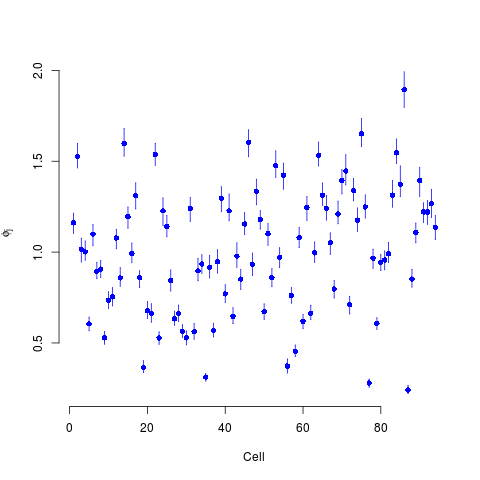

In [209]:
%%R
plot(mcmc_summary, Param = "phi")

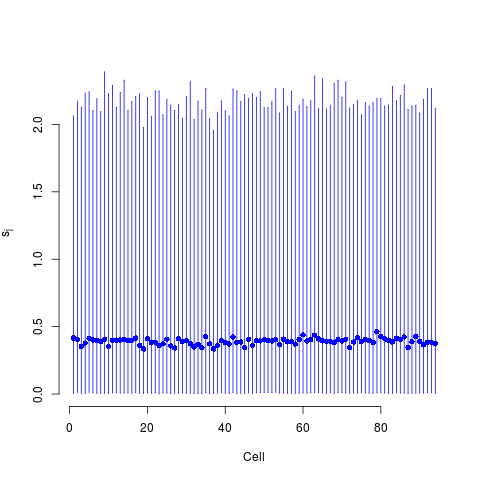

In [210]:
%%R
plot(mcmc_summary, Param = "s")

In [211]:
%%R
phi <- displaySummaryBASiCS(mcmc_summary, Param = "phi")
s <- displaySummaryBASiCS(mcmc_summary, Param = "s")
#parameters <- cbind(phi, s)
gene_count <- colSums(counts(basics_data, type = "biological"))
ercc_count <- colSums(counts(basics_data, type = "technical"))
parameters <- cbind(phi, s, gene_count, ercc_count)


In [212]:
%%R
#rownames(parameters) <- c(1:96)
parameters <- data.frame(parameters)

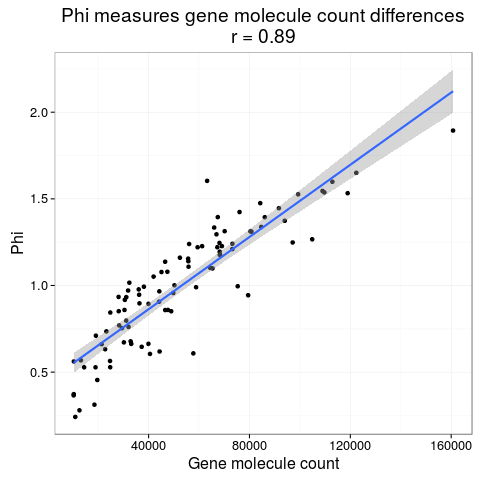

In [213]:
%%R
#png("phi_vs_Gene_Counts.png")
phi_gene_count <- ggplot(parameters, aes(x = gene_count, y = Phi)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(x = "Gene molecule count",
       title = paste0("Phi measures gene molecule count differences\nr = ",
                      round(cor(parameters$gene_count, parameters$Phi), 2)))
phi_gene_count

## S versus ERCC molecule count
As $s_j$ is determined from ERCC molecules, they are proportional to that

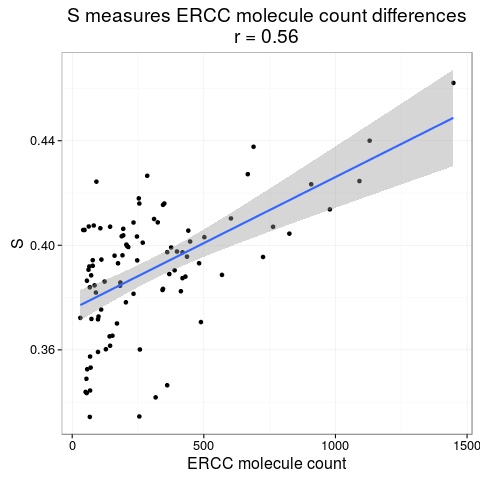

In [214]:
%%R
#png("S_vs_ERCC_Counts.png")
S_ERCC_count <- ggplot(parameters, aes(x = ercc_count, y = S)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(x = "ERCC molecule count",
       title = paste0("S measures ERCC molecule count differences\nr = ",
                      round(cor(parameters$ercc_count, parameters$S), 2)))
S_ERCC_count

## $\phi$ vs $S$

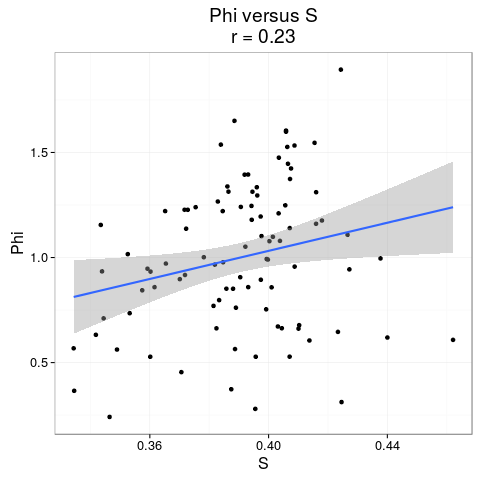

In [215]:
%%R
#png("phi_vs_S.png")
phi_s <- ggplot(parameters, aes(x = S, y = Phi)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(       title = paste0("Phi versus S\nr = ",
                      round(cor(parameters$S, parameters$Phi), 2)))
phi_s

## Denoised data

The function `BASiCS_DenoisedCounts(Data=Data, Chain = MCMC_Output)` produce a matrix of normalized counts for which the effect of technical variation is removed 

For each gene $i$ and cell $j$ this function returns

$$ x^*_{ij} = \frac{ x_{ij} } {\hat{\phi}_j \hat{\nu}_j}, $$

where $x_{ij}$ is the observed expression count of gene $i$ in cell $j$, $\hat{\phi}_j$ denotes the posterior median of $\phi_j$ and $\hat{\nu}_j$ is the posterior median of $\nu_j$.

Remove technical noise (i.e. normalize using the ERCC spike-ins). This takes a long time!

In [216]:
%%R
denoised = BASiCS_DenoisedCounts(Data = basics_data, Chain = mcmc_output)
write.table(denoised, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT/basics-denoised.txt", quote = FALSE,
            sep = "\t", col.names = NA)

Alternativelly, the user can compute the normalised and denoised expression rates underlying the expression of all genes across cells using `BASiCS_DenoisedRates`. The output of this function is given by 

$$ \Lambda_{ij} = \hat{\mu_i} \hat{\rho}_{ij},  $$

where $\hat{\mu_i}$ represents the posterior median of $\mu_j$ and $\hat{\rho}_{ij}$ is given by its posterior mean (Monte Carlo estimate based on the MCMC sample of all model parameters).

In [217]:
%%R
denoised_rates = BASiCS_DenoisedRates(Data = basics_data, Chain = mcmc_output)
write.table(denoised_rates, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT/basics-denoised-rates.txt", quote = FALSE,
            sep = "\t", col.names = NA)

[1] "This calculation requires a loop across the 2000 MCMC iterations"
[1] "Please be patient ... "

[1] "To see a progress report use PrintProgress = TRUE"



Chekcing for the Convergence

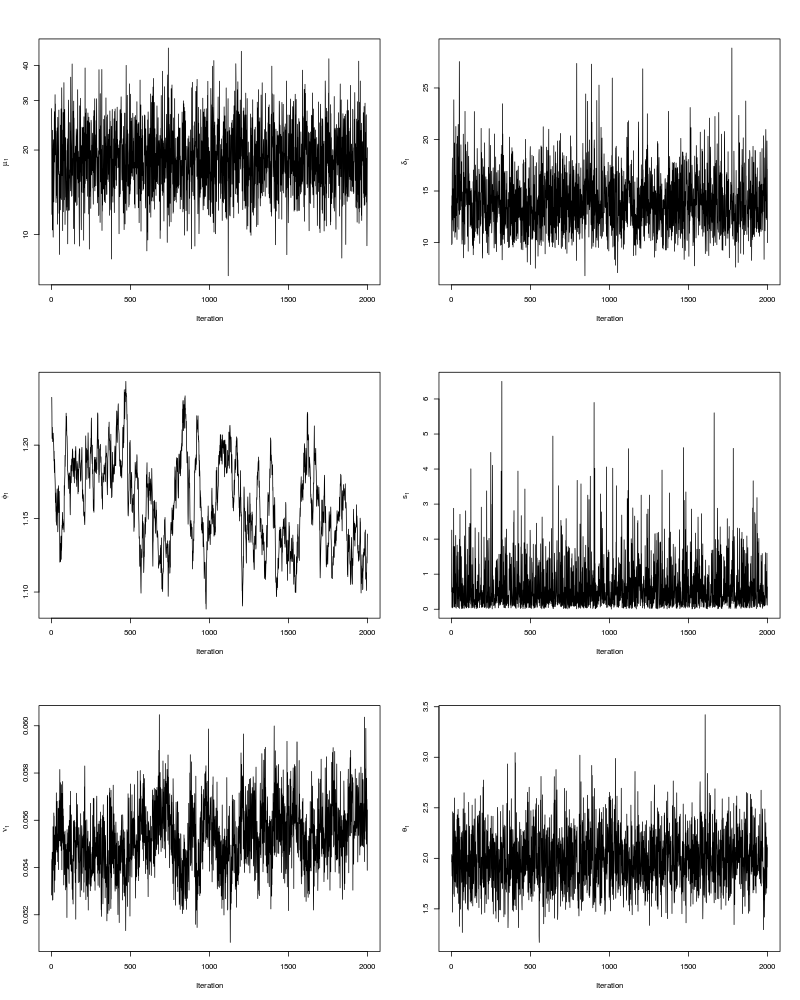

In [260]:
%%R -w 800 -h 1000
par(mfrow=c(3,2))
plot(mcmc_output, Param = "mu", Gene = 1, log = "y")
plot(mcmc_output, Param = "delta", Gene = 1)
plot(mcmc_output, Param = "phi", Cell = 1)
plot(mcmc_output, Param = "s", Cell= 1)
plot(mcmc_output, Param = "nu", Cell = 1)
plot(mcmc_output, Param = "theta", Batch = 1)

__PCA Plotting with Normalized Dataset__

This plot is generated taking both the gene counts and the ERCC spike in counts

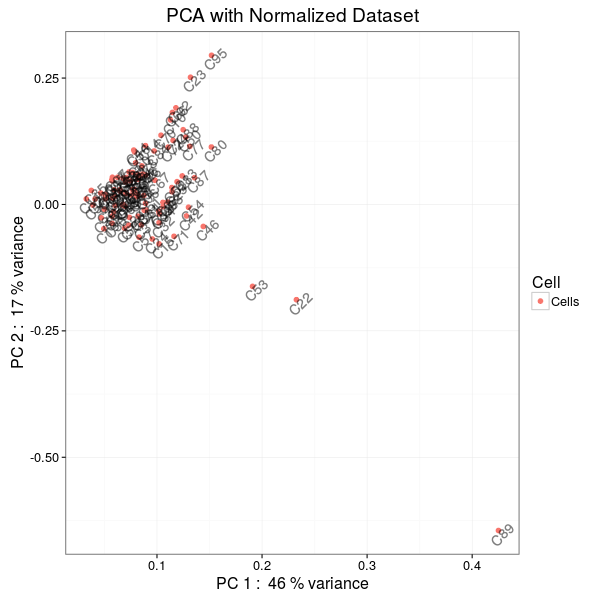

In [263]:
%%R -w 600 -h 600
FinalPCAData <- denoised
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(c(rep("Cells", CellNumber)), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Normalized Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

__PCA plotting with the raw data__

This plot is generated taking both the gene counts and the ERCC spike in counts

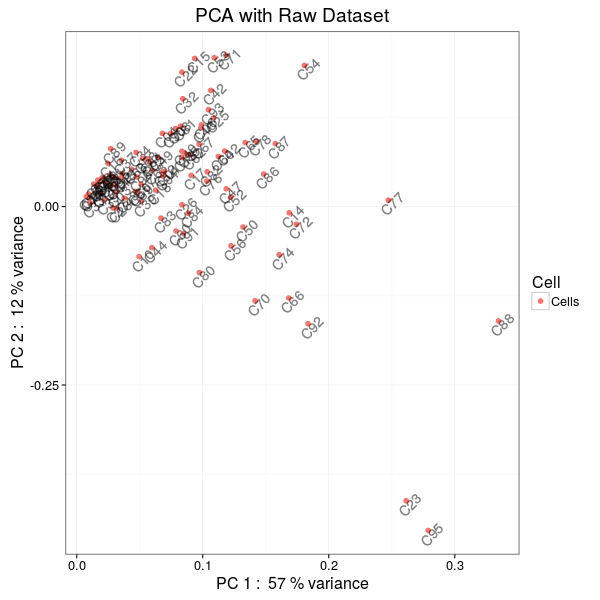

In [264]:
%%R -w 600 -h 600
FinalPCAData <- Counts
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
#png("PCA with Raw Data.png")
strain <- factor(c(rep("Cells", CellNumber)), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Raw Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

__Gene Expression per cell__

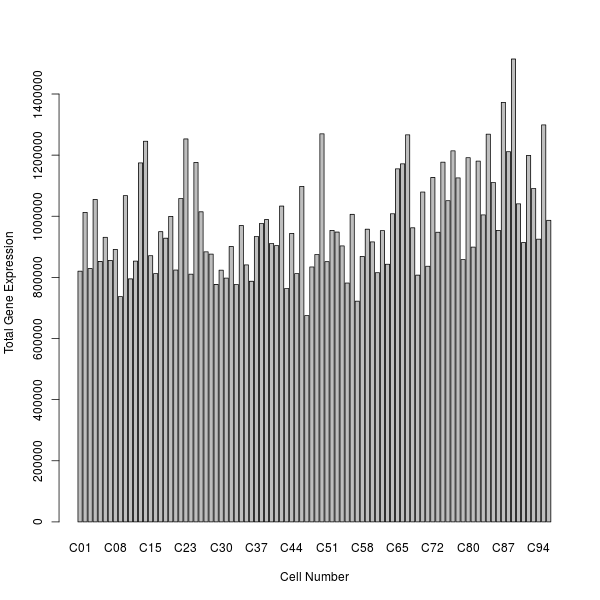

In [266]:
%%R -w 600 -h 600
CellGeneExpression <- colSums(denoised_rates)
barplot(CellGeneExpression,xlab="Cell Number", ylab="Total Gene Expression")

## SCDE for Heterogeneity analysis

The pagoda routines implemented in the scde resolves multiple, potentially overlapping aspects of transcriptional heterogeneity by identifying known pathways or novel gene sets that show significant excess of coordinated variability among the measured cells. Briefly, cell-specific error models derived from scde are used to estimate residual gene expression variance, and identify pathways and gene sets that exhibit statistically significant excess of coordinated variability (overdispersion). pagoda can be used to effectively recover known subpopulations and discover putative new subpopulations and their corresponding functional characteristics in single-cell samples. For more information, please refer to the original manuscript by [Fan et al](http://www.nature.com/nmeth/journal/vaop/ncurrent/full/nmeth.3734.html)

### Fitting error models

Next, we'll construct error models for individual cells. Here, we use k-nearest neighbor model fitting procedure implemented by `knn.error.models()` method. Our data is a UMI based data, so we raise the min.count.threshold to 1 (minimum number of reads for the gene to be initially classified as a non-failed measurement), requiring at least 5 non-failed measurements per gene. We're providing a rough guess to the complexity of the population, by fitting the error models based on 1/4 of most similar cells (i.e. guessing there might be ~4 subpopulations).

Note this step takes a considerable amount of time unless multiple cores are used. We highly recommend use of multiple cores. You can check the number of available cores available using `parallel::detectCores()`

__We had to use the raw data for this as SCDE does not accept normalized data__

In [9]:
%%R
#cdSCDE <- read.csv('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GeneAnnotationIdName.csv',check.names=FALSE,row.names=1)
CountData <- read.csv('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/AllHtseqCounts.csv',check.names=FALSE,row.names=1)
CellNumber <- dim(CountData)[2]

In [10]:
%%R
dim(CountData)

[1] 45237    96


We used the clean.counts() method from SCDE to filter the cells and genes. However, the detault parameter filtered out too much of the cells and so we had to chage it

clean.counts(counts, min.lib.size = 1800, min.reads = 10,
  min.detected = 5)
  
Arguments

| Parameters | Description |
|----------|:-------------|
| counts |  read count matrix. The rows correspond to genes, columns correspond to individual cells |
| min.lib.size |    Minimum number of genes detected in a cell. Cells with fewer genes will be removed (default: 1.8e3) |
| min.reads | Minimum number of reads per gene. Genes with fewer reads will be removed (default: 10) |
| min.detected | Minimum number of cells a gene must be seen in. Genes not seen in a sufficient number of cells will be removed (default: 5) |

We changed the `min.lib.size` to `1500`. This gives 57 cells. 

In [78]:
%%R -o cd
# omit the non-mapped gene information
cd = CountData[1:(dim(CountData)[1]-5),]
# omit genes that are never detected
 #cd <- cd[rowSums(cd[,2:dim(cd)[2]])>0, ]
# omit cells with very poor coverage
 #cd <- cd[, colSums(cd[,2:dim(cd)[2]])>1e4]
CellNumber <- dim(cd)[2]
 #GeneNames <- cbind(rownames(cd), as.character(cd[,1]))
 #colnames(GeneNames) <- c("EnsembleID", "GeneName")
 #cd$gene_name <- NULL
 #print(head(GeneNames[,1]))
cd <- clean.counts(cd, min.lib.size=1500)
dim(cd)

[1] 5934   57


In [79]:
%%R
print(colnames(cd))
colSums(cd)

 [1] "C01" "C02" "C06" "C07" "C08" "C12" "C14" "C15" "C17" "C18" "C23" "C25"
[13] "C26" "C27" "C32" "C35" "C39" "C40" "C42" "C43" "C44" "C45" "C46" "C47"
[25] "C48" "C49" "C50" "C51" "C52" "C53" "C54" "C56" "C60" "C62" "C63" "C64"
[37] "C65" "C66" "C68" "C69" "C70" "C71" "C72" "C74" "C76" "C77" "C78" "C81"
[49] "C85" "C86" "C87" "C88" "C91" "C92" "C93" "C94" "C95"
   C01    C02    C06    C07    C08    C12    C14    C15    C17    C18    C23 
 49448  94545  61017  37446  41530  41298 107122  63496  76533  28473 103468 
   C25    C26    C27    C32    C35    C39    C40    C42    C43    C44    C45 
 63758  51980  23436  52781  26201  34407  61495  57592  34895  34117  26750 
   C46    C47    C48    C49    C50    C51    C52    C53    C54    C56    C60 
 53367  59285  29805  62264  64553  28400  60564  44668  79396  71570  44791 
   C62    C63    C64    C65    C66    C68    C69    C70    C71    C72    C74 
 63986  37575  71498 111891  76109  40171  28925  70542  62998  86532  81112 
   C76   

In [92]:
%%R
rownames(cd) <- gsub("\\..*","",rownames(cd))
head(rownames(cd))

[1] "ENSMUSG00000000001" "ENSMUSG00000000028" "ENSMUSG00000000078"
[4] "ENSMUSG00000000088" "ENSMUSG00000000131" "ENSMUSG00000000134"


In [374]:
%%R
GeneNames[,1] <- gsub("\\..*","",GeneNames[,1])
GeneNamesList <- split(GeneNames, rep(1:ncol(GeneNames), each = nrow(GeneNames)))

In [93]:
%%R
knn <- knn.error.models(cd, k = ncol(cd)/4, n.cores = 2, min.count.threshold = 1, min.nonfailed = 5, save.model.plots = TRUE, max.model.plots = 50)

In [94]:
%%R
head(knn)

      conc.b    conc.a    fail.r    corr.b corr.a corr.theta corr.ltheta.b
C01 40.43020 -12.10203 -2.302585 -3.312106      1  0.2772551    -0.5521168
C02 40.62022 -12.46316 -2.302585 -2.589788      1  0.2791042    -1.1997089
C06 38.93878 -12.06526 -2.302585 -2.897193      1  0.3025560    -0.3090681
C07 37.95658 -11.61651 -2.302585 -3.456622      1  0.2743565    -2.1794775
C08 39.15988 -12.19654 -2.302585 -3.225159      1  0.2334250    -1.9002483
C12 32.14741 -10.12504 -2.302585 -3.349348      1  0.2647223    -0.6305056
    corr.ltheta.t corr.ltheta.m corr.ltheta.s corr.ltheta.r   conc.a2
C01     48.677181     16.329360   -0.06761624    19.4601055 0.9236724
C02      2.074565      4.894402   -1.94705615     0.1000000 0.9733647
C06      1.462137      5.718557  -10.40423790     0.1000000 0.9448275
C07      3.294148     11.797585   -0.19544222     7.7717390 0.9007718
C08      4.409593      5.559800   -0.20523450     0.9323767 0.9550768
C12      1.502408      5.771130   -2.49196788     0.100

In [386]:
%%R
knnWithERCC <- knn.error.models(Counts, k = ncol(Counts)/4, n.cores = 2, min.count.threshold = 1, min.nonfailed = 5, save.model.plots = TRUE, max.model.plots = 50)

The fitting process above wrote out `cell.models.pdf` file in the current directory showing model fits for the first 50 cells

### Normalizing variance
In order to accurately quantify excess variance or overdispersion, we must normalize out expected levels of technical and intrinsic biological noise. Briefly, variance of the NB/Poisson mixture processes derived from the error modeling step are modeled as a chi-squared distribution using adjusted degrees of freedom and observation weights based on the drop-out probability of a given gene. Here, we normalize variance, trimming 3 most extreme cells and limiting maximum adjusted variance to 5.

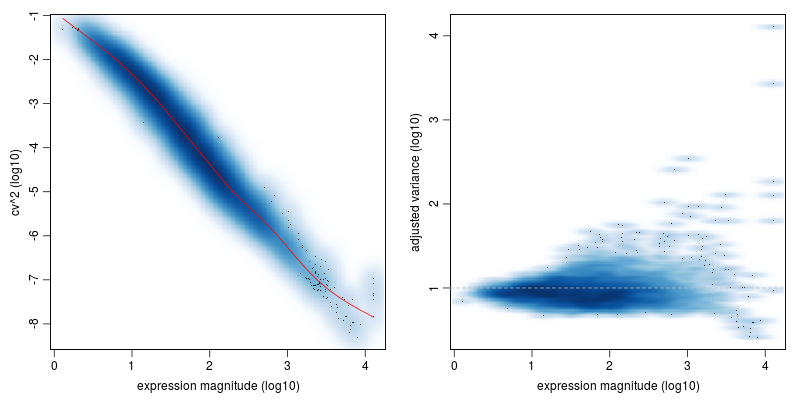

In [95]:
%%R -w 800 -h 400
varinfo <- pagoda.varnorm(knn, counts = cd, trim = 3/ncol(cd), max.adj.var = 5, n.cores = 2, plot = TRUE)

The plot on the left shows coefficient of variance squared (on log10 scale) as a function of expression magnitude (log10 FPM). The red line shows local regression model for the genome-wide average dependency. The plot on the right shows adjusted variance (derived based on chi-squared probability of observed/genomewide expected ratio for each gene, with degrees of freedom adjusted for each gene). The adjusted variance of 1 means that a given gene exhibits as much variance as expected for a gene of such population average expression magnitude. Genes with high adjusted variance are overdispersed within the measured population and most likely show subpopulation-specific expression:

__Using ERCC spike ins to fit dependency between expression magnitude and variance__

checking counts ... done
Winsorizing count matrix ... done
checking batch ... ok
calculating modes ... prior . done
calculating weight matrix ... calculating ... done
calculating effective degrees of freedom ... done
calculating normalized expression values ... . done


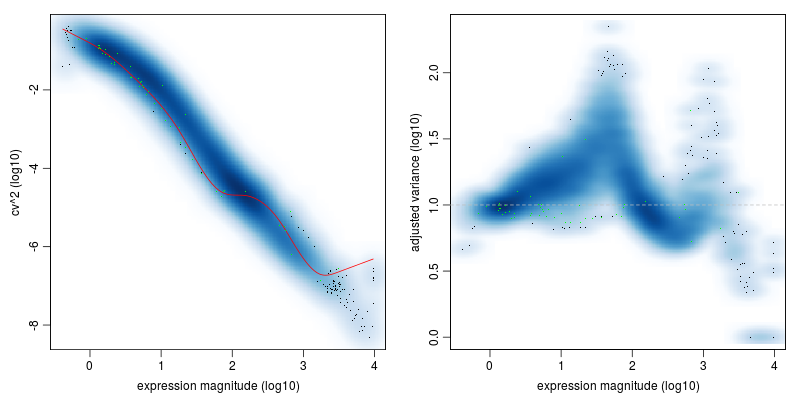

In [388]:
%%R -w 800 -h 400
ercc.genes <- grep("^ERCC-",rownames(Counts),value=T)
varinfo <- pagoda.varnorm(knnWithERCC, counts = Counts, trim = 3/ncol(Counts), fit.genes=ercc.genes,n.cores=2,plot=T,verbose=1,max.adj.var=5)

__Now fitting model with only read counts__

As the ERCC spike in data were not conclusive, here I am running the error model fitting from SCDE with only the read counts. The fitting process relies on a subset of robust genes that are detected in multiple cross-cell comparisons. 

Note this step takes a considerable amount of time unless multiple cores are used.

In [ ]:
%%R
# calculate models
#o.ifm <- scde.error.models(counts = cd, n.cores = 2, threshold.segmentation = TRUE, save.crossfit.plots = FALSE, save.model.plots = TRUE, verbose = 1)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: cross-fitting 4371 pairs:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: adjusting library size based on 2000 entries

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [96]:
%%R
# list top overdispersed genes
sort(varinfo$arv, decreasing = TRUE)[1:10]

ENSMUSG00000091405 ENSMUSG00000065037 ENSMUSG00000018930 ENSMUSG00000027184 
          4.107899           3.429358           2.539444           2.405000 
ENSMUSG00000064351 ENSMUSG00000053560 ENSMUSG00000064339 ENSMUSG00000099583 
          2.264708           2.106789           2.103305           2.016573 
ENSMUSG00000033355 ENSMUSG00000067017 
          1.971610           1.967128 


### Controlling for sequencing depth

Even with all the corrections, sequencing depth or gene coverage is typically still a major aspects of variability. In most studies, we would want to control for that as a technical artifact (exceptions are cell mixtures where subtypes significantly differ in the amount of total mRNA). Below we will control for the gene coverage (estimated as a number of genes with non-zero magnitude per cell) and normalize out that aspect of cell heterogeneity:

In [97]:
%%R
varinfo <- pagoda.subtract.aspect(varinfo, colSums(cd[, rownames(knn)]>0))

In [98]:
%%R
head(varinfo$arv)

ENSMUSG00000000001 ENSMUSG00000000028 ENSMUSG00000000078 ENSMUSG00000000088 
         1.0655631          0.9867083          1.1587569          0.7102606 
ENSMUSG00000000131 ENSMUSG00000000134 
         0.8667280          1.0702682 


### Evaluate overdispersion of pre-defined gene sets

In order to detect significant aspects of heterogeneity across the population of single cells, 'pagoda' identifies pathways and gene sets that exhibit statistically significant excess of coordinated variability. Specifically, for each gene set, we tested whether the amount of variance explained by the first principal component significantly exceed the background expectation. 

__ Using Ensembl's BioMart service to get the GO annotations__

In [346]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ensembl"))
# Use mmusculus_gene_ensembl for mouse
# For mouse symbols we can use "mgi_symbol"
ensembl = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# Constructs a dataframe with two columns: hgnc_symbol and go_id
# If rownames are Ensembl IDs, use ensembl_gene_id as filter value
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = gsub("\\.[0-9]+", "", rownames(cd)), mart = ensembl)
go = getBM(attributes = c("ensembl_gene_id", "mgi_symbol", "go_id"), filters = "ensembl_gene_id", values = rownames(cd), mart = ensembl)
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), mart = ensembl)

# Use the GO.db library to add a column with the GO-term to the dataframe
go$term = Term(go$go_id)

# Create a named list of character vectors out of the df
s = split(go$ensembl_gene_id, paste(go$go_id,go$term),go$mgi_symbol)

# Saves the list as a R environment
go.env = list2env(s)

In [407]:
%%R
# Create a named list of character vectors out of the df
s = split(cbind(go$ensembl_gene_id, go$mgi_symbol), paste(go$go_id,go$term))
# Saves the list as a R environment
go.env = list2env(s)

In [408]:
%%R
head(ls(go.env))

[1] "GO:0000002 mitochondrial genome maintenance"                  
[2] "GO:0000003 reproduction"                                      
[3] "GO:0000010 trans-hexaprenyltranstransferase activity"         
[4] "GO:0000011 vacuole inheritance"                               
[5] "GO:0000012 single strand break repair"                        
[6] "GO:0000014 single-stranded DNA endodeoxyribonuclease activity"


In [354]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ensembl"))
# Use mmusculus_gene_ensembl for mouse
# For mouse symbols we can use "mgi_symbol"
ensembl = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# Constructs a dataframe with two columns: hgnc_symbol and go_id
# If rownames are Ensembl IDs, use ensembl_gene_id as filter value
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = gsub("\\.[0-9]+", "", rownames(cd)), mart = ensembl)
goVarinfo = getBM(attributes = c( "mgi_symbol", "go_id"), filters = "ensembl_gene_id", values = rownames(cd), mart = ensembl)
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), mart = ensembl)

# Use the GO.db library to add a column with the GO-term to the dataframe
goVarinfo$term = Term(goVarinfo$go_id)

# Create a named list of character vectors out of the df
s = split(goVarinfo$ensembl_gene_id, paste(goVarinfo$go_id,goVarinfo$term),goVarinfo$mgi_symbol)

# Saves the list as a R environment
goVarinfo.env = list2env(s)


Error in split.default(goVarinfo$ensembl_gene_id, paste(goVarinfo$go_id,  : 
  first argument must be a vector


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in split.default(goVarinfo$ensembl_gene_id, paste(goVarinfo$go_id,  : 
  first argument must be a vector

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [359]:
%%R
# Use the GO.db library to add a column with the GO-term to the dataframe
goVarinfo$term = Term(goVarinfo$go_id)

# Create a named list of character vectors out of the df
s = split(goVarinfo$mgi_symbol, paste(goVarinfo$go_id,goVarinfo$term))

# Saves the list as a R environment
goVarinfo.env = list2env(s)

In [381]:
%%R
# Saving the GO terms with Gene names
GOAnnotated <- cbind(go$ensembl_gene_id,go$go_id,go$term)
write.csv(GOAnnotated, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GOAnnotated.csv", row.names=T)

In [413]:
%%R
head(ls(go.env)) # Look at gene set names

[1] "GO:0000002 mitochondrial genome maintenance"                  
[2] "GO:0000003 reproduction"                                      
[3] "GO:0000010 trans-hexaprenyltranstransferase activity"         
[4] "GO:0000011 vacuole inheritance"                               
[5] "GO:0000012 single strand break repair"                        
[6] "GO:0000014 single-stranded DNA endodeoxyribonuclease activity"


In [409]:
%%R
head(get(ls(go.env), go.env)) # Look at one gene set

[1] "ENSMUSG00000022889" "ENSMUSG00000030557" "ENSMUSG00000030879"
[4] "ENSMUSG00000032449" "ENSMUSG00000033845" "ENSMUSG00000038084"


In [410]:
%%R
ngenes <- unlist(lapply(as.list(go.env),function(x) sum(x %in% rownames(varinfo$mat))))
#ngenes <- unlist(lapply(as.list(go.env),function(x) x))
head(ngenes)

                     GO:0055102 lipase inhibitor activity 
                                                        1 
                       GO:0035173 histone kinase activity 
                                                        4 
        GO:0070125 mitochondrial translational elongation 
                                                        4 
        GO:0034162 toll-like receptor 9 signaling pathway 
                                                        3 
GO:0003073 regulation of systemic arterial blood pressure 
                                                        1 
              GO:0060279 positive regulation of ovulation 
                                                        1 


Now, we can calculate weighted first principal component magnitudes for each GO gene set in the provided environment.

In [246]:
%%R
pwpca <- pagoda.pathway.wPCA(varinfo, go.env, n.components = 1, n.cores = 2, verbose=TRUE)

In [249]:
%%R
#pwpca[[1]]

NULL


We can now evaluate the statistical significance of the observed overdispersion for each GO gene set.

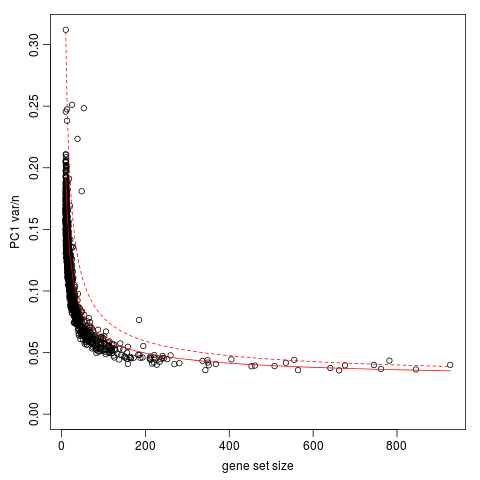

In [250]:
%%R
df <- pagoda.top.aspects(pwpca, return.table = TRUE, plot = TRUE, z.score = 1.96)

Each point on the plot shows the PC1 variance (lambda1) magnitude (normalized by set size) as a function of set size. The red lines show expected (solid) and 95% upper bound (dashed) magnitudes based on the Tracey-Widom model.

In [251]:
%%R
head(df, 20)

                                                   name npc   n    score
51                                GO:0000786 nucleosome   1  53 3.091230
21               GO:0000183 chromatin silencing at rDNA   1  38 2.389019
340  GO:0006352 DNA-templated transcription, initiation   1  25 2.176690
334                      GO:0006334 nucleosome assembly   1  48 2.155751
1249    GO:0070098 chemokine-mediated signaling pathway   1  10 1.598117
1116     GO:0046982 protein heterodimerization activity   1 185 1.508125
1279   GO:0071346 cellular response to interferon-gamma   1  13 1.486630
1048                     GO:0044822 poly(A) RNA binding   1 782 1.199955
142                              GO:0003677 DNA binding   1 555 1.139930
626           GO:0016021 integral component of membrane   1 927 1.138212
             z     adj.z sh.z adj.sh.z
51   17.803188 17.394558   NA       NA
21   11.667846 11.099295   NA       NA
340   9.004593  8.341194   NA       NA
334  10.763810 10.185108   NA       NA
12

- The z column gives the Z-score of pathway over-dispersion relative to the genome-wide model (Z-score of 1.96 corresponds to P-value of 5%, etc.).
- "z.adj" column shows the Z-score adjusted for multiple hypothesis (using Benjamini-Hochberg correction).
- "score" gives observed/expected variance ratio
- "sh.z" and "adj.sh.z" columns give the raw and adjusted Z-scores of "pathway cohesion", which compares the observed PC1 magnitude to the magnitudes obtained when the observations for each gene are randomized with respect to cells. When such Z-score is high (e.g. for GO:0008009) then multiple genes within the pathway contribute to the coordinated pattern.


## Evaluate overdispersion of 'de novo' gene sets

We can also test 'de novo' gene sets whose expression profiles are well-correlated within the given dataset. The following procedure will determine 'de novo' gene clusters in the data, and build a background model for the expectation of the gene cluster weighted principal component magnitudes. Note the higher trim values for the clusters, as we want to avoid clusters that are formed by outlier cells.



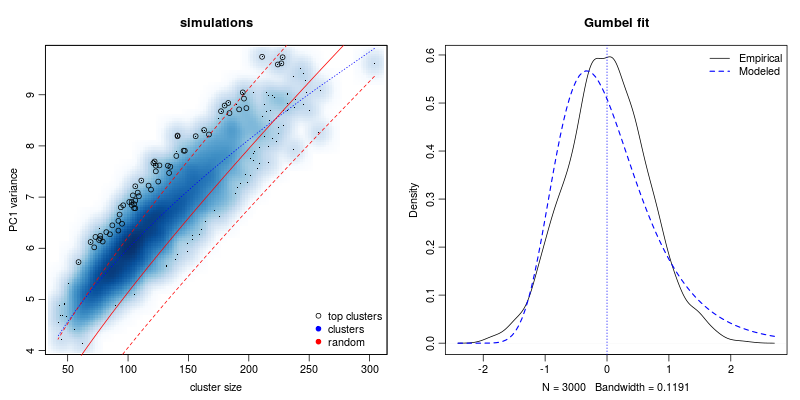

In [252]:
%%R -w 800 -h 400
library(extRemes)
library(Lmoments)
library(distillery)
library(car)

clpca <- pagoda.gene.clusters(varinfo, trim = 7.1/ncol(varinfo$mat), n.clusters = 50, n.cores = 2, plot = TRUE)

The plot above shows background distribution of the first principal component (PC1) variance (lambda1) magnitude. The blue scatterplot on the left shows lambda1 magnitude vs. cluster size for clusters determined based on randomly-generated matrices of the same size. The black circles show top cluster in each simulation. The red lines show expected magnitude and 95% confidence interval based on Tracy-Widom distribution. The right plot shows extreme value distribution fit of residual cluster PC1 variance magnitude relative to the Gumbel (extreme value) distribution.

Now the set of top aspects can be recalculated taking these de novo gene clusters into account:

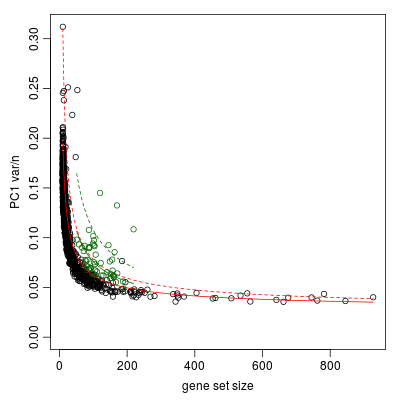

In [253]:
%%R -w 400 -h 400
df <- pagoda.top.aspects(pwpca, clpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
write.table(df, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/BASiCS_OUTPUT/TopAspects.txt", quote = FALSE,
            sep = "\t", col.names = NA)

The gene clusters and their corresponding model expected value and 95% upper bound are shown in green.

## Visualize significant aspects of heterogeneity

To view top heterogeneity aspects, we will first obtain information on all the significant aspects of transcriptional heterogeneity. We will also determine the overall cell clustering based on this full information:

In [254]:
%%R
# get full info on the top aspects
tam <- pagoda.top.aspects(pwpca, clpca, n.cells = NULL, z.score = qnorm(0.01/2, lower.tail = FALSE))
# determine overall cell clustering
hc <- pagoda.cluster.cells(tam, varinfo)

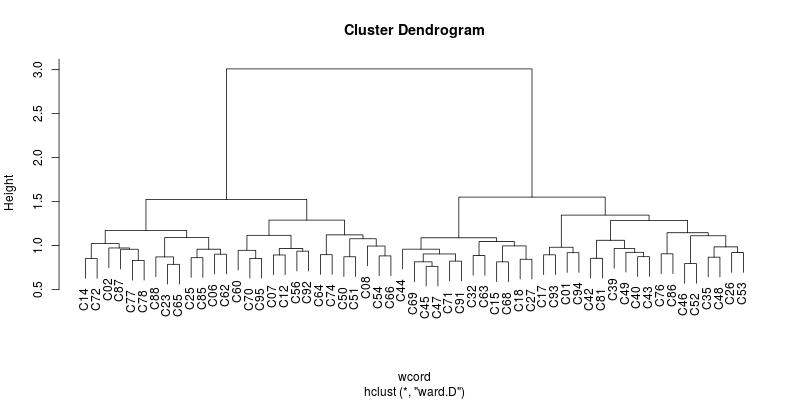

In [255]:
%%R -w 800 -h 400
plot(hc)

Next, we will reduce redundant aspects in two steps. First we will combine pathways that are driven by the same sets of genes:

In [256]:
%%R
tamr <- pagoda.reduce.loading.redundancy(tam, pwpca, clpca)

In the second step we will combine aspects that show similar patterns (i.e. separate the same sets of cells). Here we will plot the cells using the overall cell clustering determined above:

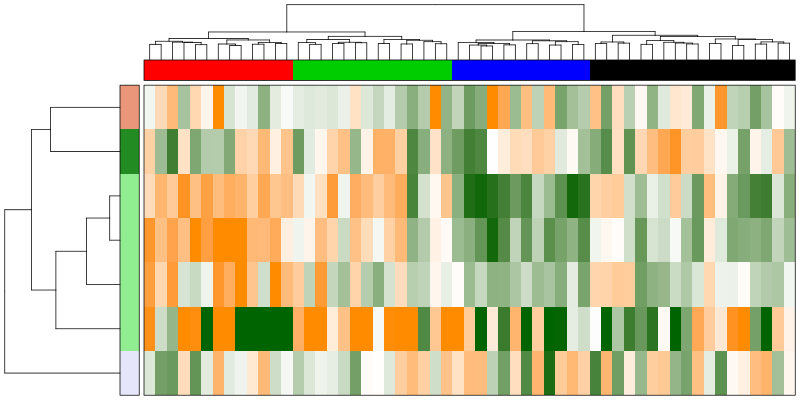

In [257]:
%%R -w 800 -h 400
tamr2 <- pagoda.reduce.redundancy(tamr, distance.threshold = 0.9, plot = TRUE, cell.clustering = hc, labRow = NA, labCol = NA, box = TRUE, margins = c(0.5, 0.5), trim = 0, col.cols = rbind(groups = cutree(hc, 4)))

In the plot above, the columns are cells, rows are different significant aspects, clustered by their similarity pattern.The green-to-orange color scheme shows low-to-high weighted PCA scores (aspect patterns), where generally orange indicates higher expression. Blocks of color on the left margin show which aspects have been combined by the command above. Here the number of resulting aspects is relatively small. "top" argument (i.e. top = 10) can be used to limit further analysis to top N aspects.

We will view the top aspects, clustering them by pattern similarity (note, to view aspects in the order of increasing `lambda1` magnitude, use `row.clustering = NA`).

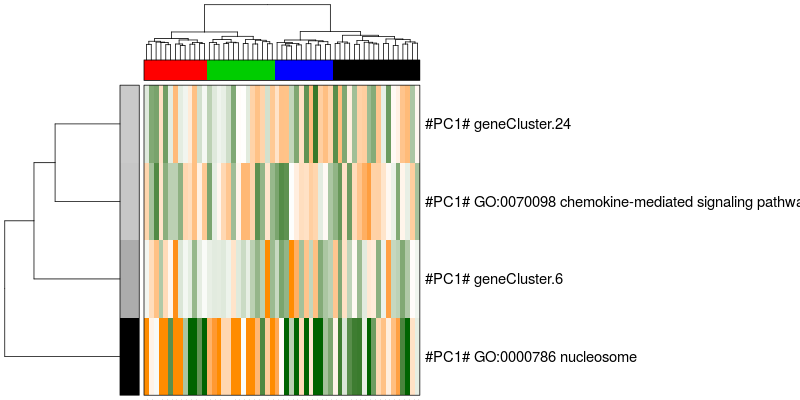

In [258]:
%%R -w 800 -h 400
pagoda.view.aspects(tamr2, cell.clustering = hc, box = TRUE, labCol = hc, margins = c(0.5, 40), col.cols = rbind(groups = cutree(hc, 4)))

In [220]:
%%R
go.env
#save.image()

<environment: 0x17dcab90>


In [353]:
%%R
varinfoTest <- varinfo
testVarinfo <- cbind((goVarinfo$ensembl_gene_id),(goVarinfo$mgi_symbol))
dim(testVarinfo)
#rownames(varinfoTest$mat)<- test[rownames(varinfoTest$mat) == test[,1],2]
#test[(rownames(varinfoTest$mat)[1]) == (test[,1]),][1,2]
#for(i in 1:dim(varinfoTest$mat)[1]){
#    print(test[rownames(varinfoTest$mat)[i] == test[,1],][1,])
#    print(i)
#}


[1] 86394     2


In [334]:
%%R
print(rownames(varinfoTest$mat)[1148])

[1] "ENSMUSG00000021326"


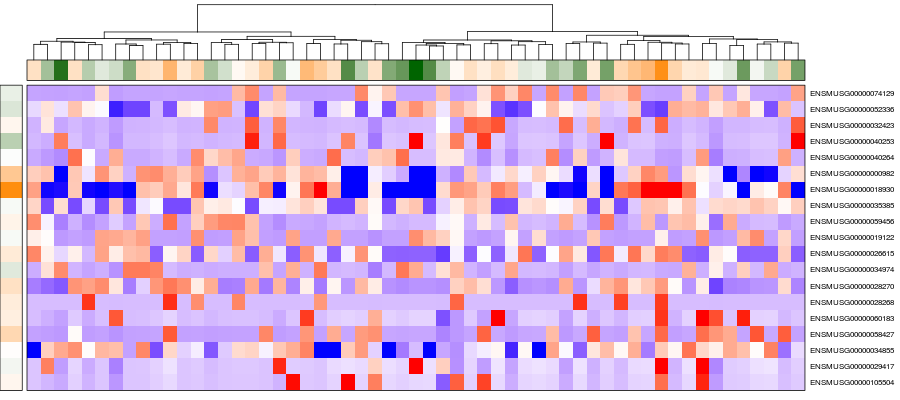

In [343]:
%%R -w 900 -h 400
test<- pagoda.show.pathways(c("GO:0071346 cellular response to interferon-gamma","GO:0070098 chemokine-mediated signaling pathway"), varinfo, go.env, cell.clustering = hc, margins = c(1,10), show.cell.dendrogram = TRUE, showRowLabels = TRUE, showPC = TRUE)

In [345]:
%%R
test

       C01        C02        C06        C07        C08        C12        C14 
 0.7900567 -4.1182913  0.7838636  0.7126800 -1.2727019  1.6970026  1.2168732 
       C15        C17        C18        C23        C25        C26        C27 
 0.6948217 -1.1069626 -0.3239974 -2.2943146  0.9897118  1.7162997 -1.7056180 
       C32        C35        C39        C40        C42        C43        C44 
 0.6711983 -0.1556506  2.8295890  1.6116010  1.5757403  0.8446784 -2.9350535 
       C45        C46        C47        C48        C49        C50        C51 
-3.2695440 -0.5782961 -1.1460828 -0.9688310  4.3890247  1.1495638 -3.2856047 
       C52        C53        C54        C56        C60        C62        C63 
-2.8003142 -2.6814182  1.1250552 -1.9030273 -1.6848754  1.8328840  1.3253098 
       C64        C65        C66        C68        C69        C70        C71 
 2.7086041  1.1603307 -2.3867505 -0.5700699 -4.4864389 -0.8085153  0.2319903 
       C72        C74        C76        C77        C78        C8

In [146]:
%%R
# compile a browsable app, showing top three clusters with the top color bar
app <- make.pagoda.app(tamr2, tam, varinfo, go.env, pwpca, clpca, col.cols = col.cols, cell.clustering = hc, title = "NPCs")
# show app in the browser (port 1468)
show.app(app, "James_Cluster", browse = TRUE, port = 1468) 

Server started on 127.0.0.1:1468
[1] RookTest      http://127.0.0.1:1468/custom/RookTest
[2] pollen        http://127.0.0.1:1468/custom/pollen
[3] James_Cluster http://127.0.0.1:1468/custom/James_Cluster

Call browse() with an index number or name to run an application.
